# Q1

<div dir='rtl'>
    ابتدا تصاویر را می‌خوانیم.
</div>

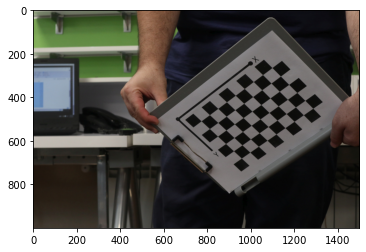

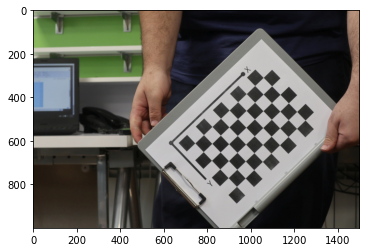

In [1]:
# import libraries and read image
import numpy as np
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('im01.jpg') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1);
plt.show()

img2 = cv2.imread('im02.jpg') 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2);
plt.show()

<div dir='rtl'>
    حال برای پیدا کردن 
    edge
    ها از تابع آماده
    cv2.Canny()
    استفاده می‌کنیم. این تابع دو مقدار
    threshold
    برای نگه داشتن 
    edge
    های قوی‌تر دارد که ما آن‌ها را
    ۳۲۵ 
    و
    ۳۵۰
    در نظر می‌گیریم. همچنین
    L2gradient
    را معادل با
    True
    در نظر می‌گیریم که 
    edge
    های ما با استفاده از
    L2gradient
    به دست بیایند.
</div>

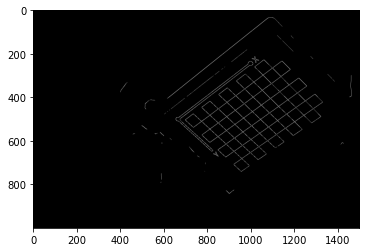

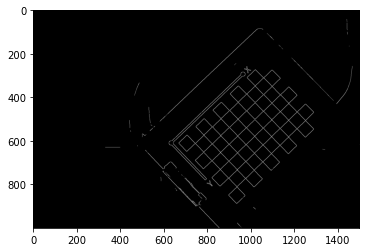

True

In [2]:
# get_edges
edges1 = cv2.Canny(img1, 325, 350, L2gradient=True)
plt.imshow(edges1, cmap='gray');
plt.show()
cv2.imwrite("res01.jpg", edges1)

edges2 = cv2.Canny(img2, 325, 350, L2gradient=True)
plt.imshow(edges2, cmap='gray');
plt.show()
cv2.imwrite("res02.jpg", edges2)

<div dir='rtl'>
    مطابق اسلاید
    hough space
    را به دست می‌آوریم. بازه مورد نظر برای 
    rho
    اگر مبدأ تصویر را نقطه وسط آن در نظر بگیریم
    $[-diagonal//2, diagonal//2]$
    است که
    diagonal
    معادل با قطر تصویر است.
    همچنین برای طی کردن این بازه ۴۰۰ گام باید طی کنیم.
    theta
    بازه ۰ تا ۱۸۰ درجه است زیرا تمام شیب خط‌ها را پوشش می‌دهد.
    برای طی کردن این ۱۸۰ درجه نیز 
    ۴۰۰
    گام طی می‌کنیم.
</div>

In [3]:
# create hough space rho between (-diagonal//2, diagonal//2) and theta between 0 and pi
# rho steps = 400 and theta steps = 400
def get_hough_space(img, rho_size=400, theta_size=400):
    hough_space = np.zeros((rho_size, theta_size))
    diagonal = np.sqrt(img.shape[0]**2 + img.shape[1]**2)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j]:
                for theta_idx in range(theta_size):
                    theta = theta_idx / theta_size * np.pi
                    rho = (i - img.shape[0]//2) * np.cos(theta) + (j - img.shape[1]//2) * np.sin(theta) 
                    rho_idx = int(rho / diagonal * rho_size + rho_size/2)
                    hough_space[rho_idx][theta_idx] += 1
    return hough_space

<div dir='rtl'>
    نمایش
    hough space
    ها را در قسمت زیر داریم.
</div>

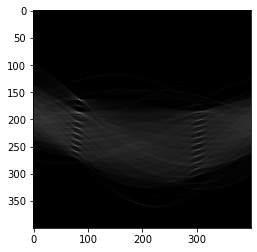

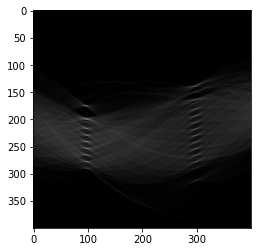

True

In [6]:
hough_space1 = get_hough_space(edges1)
plt.imshow(hough_space1, cmap='gray');
plt.show()
save = hough_space1
save = np.uint8(save / np.max(save) * 255)
cv2.imwrite("res03-hough-space.jpg", save)

hough_space2 = get_hough_space(edges2)
plt.imshow(hough_space2, cmap='gray');
plt.show()
save = hough_space2
save = np.uint8(save / np.max(save) * 255)
cv2.imwrite("res04-hough-space.jpg", save)

<div dir='rtl'>
    حال می‌خواهیم خطوط مورد نظر را به دست آوریم. برای این کار تابع
    get_local_maximas()
    را پیاده‌سازی می‌کنیم.
    تعداد خط‌هایی که می‌خواهیم از تصویر به دست آید را نیز به عنوان ورودی می‌دهیم. در این جا چون لبه‌های شاسی هم به عنوان خط به دست می‌آیند تعداد خطوط اولیه را کمی بیشتر از خطوط صفحه شطرنجی در نظر می‌گیریم.
    حال برای به دست آوردن نقاط سفید پررنگ در 
    hough space
    به تعداد خط‌ها ماکسیمم در 
    hough space
    به دست آورده سپس ناحیه همسایه این نقطه را صفر می‌کنیم و این کار را آن قدر تکرار می‌کنیم تا به تعداد خط مورد نظر خط نقطه‌های
    rho
    و
    theta
    به دست آوریم.
    پس از به دست آوردن 
    rho
    ها
    و
    theta
    ها
    چون خط‌های شاسی هم به دست می‌آیند و ما آن‌ها را نمی‌خواهیم،
    فاصله بین این 
    rho
    و
    theta
    ها را به دست می‌آوریم و با به دست آوردن
    percentile
    ها
    یا به بیان دیگر
    quatile
    ها
    خط‌های
    outlier
    را به دست آورده و آن‌ها را حذف می‌کنیم.
    <br>
    سپس تابع
    draw_lines()
    را پیاده‌سازی می‌کنیم. این تابع با توجه به
    rho
    و
    theta
    ها دو نقطه از خط‌های مورد نظر را به دست می‌آورد و با استفاده از تابع 
    cv2.line()
    خطوط را رسم می‌کند.
</div>

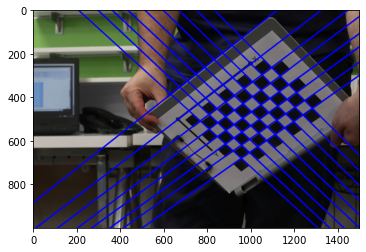

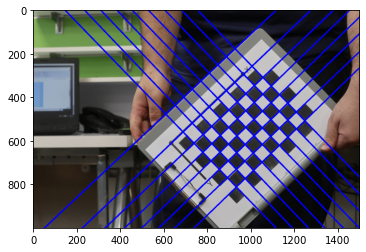

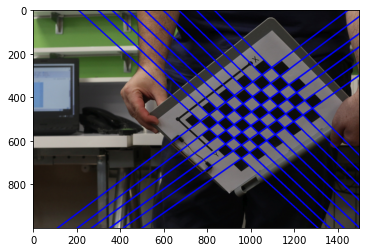

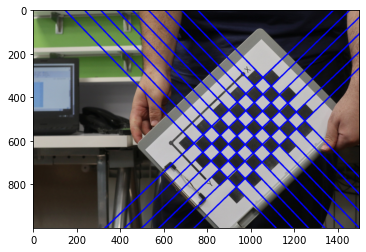

True

In [7]:
# a function to get the highest points in hough space and return rhos and thetas
def get_local_maximas(hough_space, number_of_lines=17):
    # get local maximas
    arr = np.array(hough_space)
    local_maximas = []
    for i in range(number_of_lines):
        y, x = np.unravel_index(arr.argmax(), hough_space.shape)
        arr[y-4:y+5, x-4:x+5] = 0
        local_maximas.append([y, x])
        
    # detect outliers
    dists = []
    for i in range(len(local_maximas)):
        i_dists = []
        for j in range(len(local_maximas)):
            item1 = local_maximas[i]
            item2 = local_maximas[j]
            if i != j:
                i_dists.append([int(np.sqrt((item1[0]-item2[0])**2 + (item1[1]-item2[1])**2)), i, j])
        dists.append(min(i_dists))
    dists = np.array(dists)
    
    Q1 = np.percentile(dists[:, 0], 25, interpolation = 'midpoint')
    Q3 = np.percentile(dists[:, 0], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    
    # select lines that are not outlier
    selected_maximas = []
    for i in range(len(local_maximas)):
        if dists[i][0] < threshold:
            selected_maximas.append(local_maximas[i])
    return local_maximas, selected_maximas


# a function to draw the lines of chess board
def draw_lines(img, maximas, rho_size=400, theta_size=400):
    arr = maximas
    diagonal = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    for i_and_j in arr:
        rho_idx, theta_idx = i_and_j[0], i_and_j[1]
        rho = (rho_idx - rho_size/2) * 1.0 / rho_size * diagonal
        theta = theta_idx * 1.0 / theta_size * np.pi
        y = int(rho * np.cos(theta) + img.shape[0]/2)
        x = int(rho * np.sin(theta) + img.shape[1]/2)
        img = cv2.line(np.array(img), 
                       (x - int(2000 * np.cos(theta)), y + int(2000 * np.sin(theta))),
                       (x + int(2000 * np.cos(theta)), y - int(2000 * np.sin(theta))),
                       (0, 0, 255), 5)
    return img


local_maximas1, selected_maximas1 = get_local_maximas(hough_space1)
drawn_img_all_lines1 = draw_lines(img1, local_maximas1)
plt.imshow(drawn_img_all_lines1);
plt.show()
save = cv2.cvtColor(drawn_img_all_lines1, cv2.COLOR_RGB2BGR)
cv2.imwrite("res05-lines.jpg", save)

local_maximas2, selected_maximas2 = get_local_maximas(hough_space2)
drawn_img_all_lines2 = draw_lines(img2, local_maximas2)
plt.imshow(drawn_img_all_lines2);
plt.show()
save = cv2.cvtColor(drawn_img_all_lines2, cv2.COLOR_RGB2BGR)
cv2.imwrite("res06-lines.jpg", save)

drawn_img_selected_lines1 = draw_lines(img1, selected_maximas1)
plt.imshow(drawn_img_selected_lines1);
plt.show()
save = cv2.cvtColor(drawn_img_selected_lines1, cv2.COLOR_RGB2BGR)
cv2.imwrite("res07-chess.jpg", save)

drawn_img_selected_lines2 = draw_lines(img2, selected_maximas2)
plt.imshow(drawn_img_selected_lines2);
plt.show()
save = cv2.cvtColor(drawn_img_selected_lines2, cv2.COLOR_RGB2BGR)
cv2.imwrite("res08-chess.jpg", save)

<div dir='rtl'>
    برای پیدا کردن نقاط تلاقی و رسم آن‌ها تابع
    draw_dots()
    پیاده‌سازی می‌کنیم.
    این تابع با توجه به 
    rho
    و
    theta
    های به دست آمده در قسمت قبل، یک حلقه تو در تو بر روی خط‌ها می‌زند و هر دو خط را با هم مقایسه می‌کند و با استفاده از تابع 
    line_intersection()
    تشخیص می‌دهد که این دو خط با هم برخورد دارند یا نه و اگر برخورد دارند، نقطه محل تلاقی چیست.
    سپس با استفاده از تابع
    cv2.circle()
    این نقطه را بر روی تصویر نمایش می‌دهد.
    توجه کنید که تابع 
    line_intersection()
    از روش دترمینان برای به دست آوردن پاسخ معادله 
    (تلاقی دو خط)
    استفاده می‌کند.
</div>

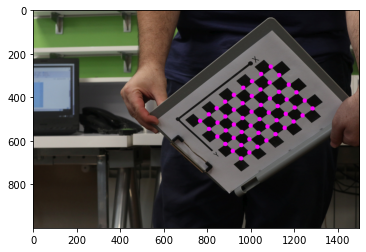

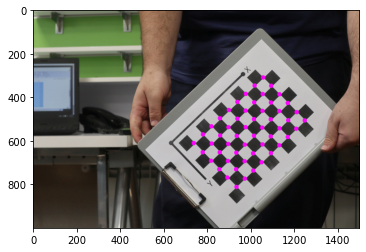

True

In [8]:
# calculate the determinant
def det(a, b):
        return a[0] * b[1] - a[1] * b[0]
    
    
# calculate intersection of two lines
def line_intersection(line1, line2):
    dx = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    dy = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    determinan = det(dx, dy)
    if determinan == 0:
        return None
    
    d = (det(line1[0], line1[1]), det(line2[0], line2[1]))
    x = det(d, dx) // determinan
    y = det(d, dy) // determinan
    return x, y


# calculate two dots of a given line (line a given using theta_idx and rho_idx)
def get_line(img, rho_idx, theta_idx, rho_size, theta_size, diagonal):
    rho = (rho_idx - rho_size/2) * 1.0 / rho_size * diagonal
    theta = theta_idx * 1.0 / theta_size * np.pi
    y = int(rho * np.cos(theta) + img.shape[0]/2)
    x = int(rho * np.sin(theta) + img.shape[1]/2)
    x1 = x - int(50 * np.cos(theta))
    y1 = y + int(50 * np.sin(theta))
    x2 = x + int(50 * np.cos(theta))
    y2 = y - int(50 * np.sin(theta))
    return [[x1, y1], [x2, y2]]


# a function to draw the dots
def draw_dots(img, hough_space, rho_size=400, theta_size=400):
    arr = get_local_maximas(hough_space)[1]
    diagonal = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    dotted_img = np.array(img)
    img = np.array(img)
    dots = []
    for ij1 in arr:
        rho_idx, theta_idx = ij1[0], ij1[1]
        line1 = get_line(img, rho_idx, theta_idx, rho_size, theta_size, diagonal)
        for ij2 in arr:
            rho_idx, theta_idx = ij2[0], ij2[1]
            line2 = get_line(img, rho_idx, theta_idx, rho_size, theta_size, diagonal)
            intersection = line_intersection(line1, line2)
            if intersection is not None:
                dotted_img = cv2.circle(dotted_img, intersection, radius=10, color=(255, 0, 255), thickness=-1)
    return dotted_img

dotted_img1 = draw_dots(img1, hough_space1)
plt.imshow(dotted_img1);
plt.show()
save = cv2.cvtColor(dotted_img1, cv2.COLOR_RGB2BGR)
cv2.imwrite("res09-corners.jpg", save)
dotted_img2 = draw_dots(img2, hough_space2)
plt.imshow(dotted_img2);
plt.show()
save = cv2.cvtColor(dotted_img2, cv2.COLOR_RGB2BGR)
cv2.imwrite("res10-corners.jpg", save)

# Q2

<div dir='rtl'>
    ابتدا تصاویر مورد نظر را می‌خوانیم و در یک آرایه به نام 
    textures
    ذخیره می‌کنیم.
</div>

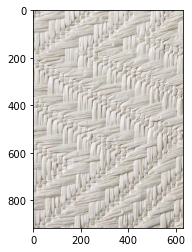

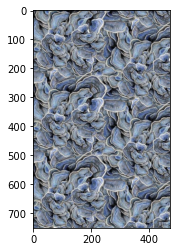

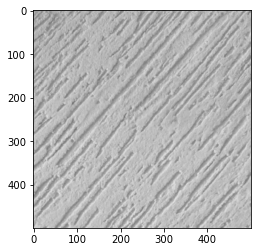

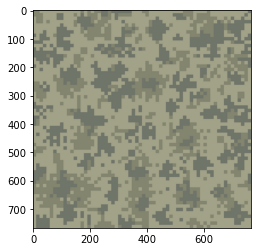

In [1]:
# import libraries and read image
import numpy as np
import cv2
import matplotlib.pyplot as plt

textures = []
file_names = ['texture02.png', 'texture11.jpeg', 'selected_texture1.png', 'selected_texture2.jpg']
for file_name in file_names:
    img = cv2.imread(file_name) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img);
    plt.show()
    textures.append(img)

<div dir='rtl'>
    برای سادگی توضیح دادن بخش‌های متفاوت ابتدا تمام موارد را برای یک بافت نشان داده سپس تمامی بافت‌ها را به طور یک جا نمایش می‌دهیم.
    حال شروع به نوشتن الگوریتم مورد نظر می‌کنیم. اولین بخشی که پیاده‌سازی می‌کنیم گرفتن یک 
    patch
    رندوم است. برای این کار دو عدد رندوم برای مختصات 
    patch
    می‌گیریم. همچنین در تابع مورد نظر دو بخش برای
    patch_size
    و
    margin
    در نظر می‌گیریم. علت وجود 
    margin
    این است که یکی از بافت‌ها حاشیه‌ای دارد که نمی‌خواهیم در بافت نهایی ما وجود داشته باشد.
</div>

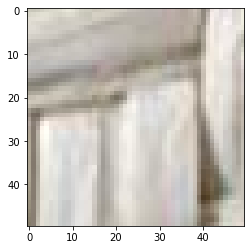

In [2]:
# select a random patch for the beginning of texture synthesis
def random_patch(texture, margin=20, patch_size=50):
    rand_i = np.random.randint(texture.shape[0] - patch_size - 2*margin)
    rand_j = np.random.randint(texture.shape[1] - patch_size - 2*margin)
    return texture[rand_i+margin:rand_i+patch_size+margin, rand_j+margin:rand_j+patch_size+margin]

patch = random_patch(textures[0])
plt.imshow(patch);

<div dir='rtl'>
    همانطور که سر کلاس گفته شد از
    matchTemplate()
    استفاده می‌کنیم تا بهترین 
    match
    را به دست آوریم. به طور مثال همان
    patch
    که در قسمت قبلی به دست آورده‌ایم و تصویر اصلی را اگر بدهیم جای دقیق همین 
    patch
    به ما داده خواهد شد.
    توجه کنید که حاشیه‌های به درد نخور تصویر حذف شده‌اند تا در مچ کردن مشکلی پیش نیاید.
</div>

In [3]:
# template match using cv2.matchTemplate
def template_match(image, template, patch_size=50, margin=20):
    margin = int(margin) + 1
    image_without_margin = image[margin:image.shape[0]-margin-patch_size][margin:image.shape[1]-margin-patch_size]
    result = cv2.matchTemplate(image_without_margin, template, cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_loc[0] + margin, max_loc[1] + margin
    
template_match(textures[0], patch)

(557, 503)

<div dir='rtl'>
    حال الگوریتم
    texture synthesis
    را پیاده‌سازی می‌کنیم.
    برای این بخش ابتدا تابع
    texture_synthesis()
    را ببینید. در این تابع ابتدا اولین
    patch
    که یک
    random patch
    است قرار می‌گیرد.
    سپس هر بار بخشی از این 
    patch
    که معمولا بخشی از سمت راست تصویر یا بخشی از پایین تصویر است را 
    template match
    با تصویر اصلی می‌زنیم و شبیه‌ترین 
    patch
    را به آن پیدا می‌کنیم.
    سپس آن را توسط تابع
    min_cut()
    با پچ قبلی که داشتیم مرج می‌کنیم.
    تابع 
    mincut
    به این صورت عمل می‌کند که کوتاه ترین مسیر در تابع 
    errors
    را می‌یابد که یعنی اگر در جهت آن مسیح پیش برویم کمترین عدم تطابق بین دو پچ را داریم.
    سپس این طور در نظر می‌گیریم که به طور مثال سمت راست را از پچ دوم و سمت چپ را از پچ اول بگیریم.
    (یا به طور مشابه بالا را از پچ اول و پایین را از پچ دوم بگیریم).
    در نظر داشته باشید که در طی اجرای این الگوریتم چون
    min_cut
    ممکن است به نواحی خالی تصویری که باید پر کنیم بگذرد، آن نواحی را با پچ پیدا شده پر می‌کنیم.
</div>

In [4]:
# find min_cut for patches filled from left to right or up to down
def min_cut(patch1, patch2, overlap, direction):
    errors = np.sum((patch1 - patch2) ** 2, axis=2)
    dp = np.ones(errors.shape) * np.inf
    best_neighbors = [[(0, 0) for j in range(errors.shape[1])] for i in range(errors.shape[0])]
    
    if direction == 0:
        dp[0, :] = errors[0, :]
        for i in range(1, dp.shape[0]):
            for j in range(dp.shape[1]):
                best_neighbors[i][j] = (i - 1, min(j, overlap))
                for neighbor in range(max(0, j - 1), min(j + 2, dp.shape[1], overlap)):
                    if dp[i - 1][neighbor] + errors[i][j] < dp[i][j]:
                        dp[i][j] = dp[i - 1][neighbor] + errors[i][j]
                        best_neighbors[i][j] = (i - 1, neighbor)
    else: 
        dp[:, 0] = errors[:, 0]                
        for j in range(1, dp.shape[1]):
            for i in range(dp.shape[0]):
                best_neighbors[i][j] = (min(i, overlap), j - 1)
                for neighbor in range(max(0, i - 1), min(i + 2, dp.shape[0], overlap)):
                    if dp[neighbor][j - 1] + errors[i][j] < dp[i][j]:
                        dp[i][j] = dp[neighbor][j - 1] + errors[i][j]
                        best_neighbors[i][j] = (neighbor, j - 1)
    
    if direction == 0:
        i, j = dp.shape[0] - 1, np.argmin(dp[-1])
    else:
        i, j = np.argmin(dp[:, -1]), dp.shape[1] - 1
    
    mixed_patch = np.array(patch2)
    while i > 0 or j > 0:
        neigh_i, neigh_j = best_neighbors[i][j]
        if direction == 0:
            mixed_patch[i, :j] = patch1[i, :j]
        else:
            mixed_patch[:i, j] = patch1[:i, j]
        i, j = neigh_i, neigh_j
    
    return mixed_patch


# a function to perform texture synthesis
def texture_synthesis(image, patch_size=280, margin=20, final_texture_size=2700, overlap_c=0.4):
    overlap = int(overlap_c * patch_size)
    n = int(np.ceil((final_texture_size - overlap)/(patch_size - overlap)))
    approx_size = (n * patch_size) - (n - 1) * overlap
    final_texture = np.zeros((approx_size, approx_size, 3), dtype=np.uint8)
    
    for i_total in range(n):
        for j_total in range(n):
            y = i_total * (patch_size - overlap)
            x = j_total * (patch_size - overlap)
            
            overlapping_patch = final_texture[y:y+patch_size, x:x+patch_size]
            patch_x, patch_y = template_match(image, overlapping_patch, margin=margin, patch_size=patch_size)
            new_patch = image[patch_y:patch_y+min(patch_size, overlapping_patch.shape[0]),
                              patch_x:patch_x+min(patch_size, overlapping_patch.shape[1])]
            
            mixed_patch = min_cut(overlapping_patch, new_patch, overlap, 1)
            mixed_patch = min_cut(overlapping_patch, mixed_patch, overlap, 0)
            
            # fill blank area with template matched patch
            r, g, b = cv2.split(mixed_patch)
            rn, gn, bn = cv2.split(new_patch)
            mixed_patch = cv2.merge((np.where(r+g+b==0, rn, r),
                                     np.where(r+g+b==0, gn, g),
                                     np.where(r+g+b==0, bn, b)))
            final_texture[y:y+mixed_patch.shape[0], x:x+mixed_patch.shape[1]] = mixed_patch
    return final_texture[-2500:, -2500:]

In [244]:
# create all textures
patch_sizes = [280, 180, 200, 350]
overlap_cs = [0.4, 0.4, 0.4, 0.2]

for i in range(4):
    patch_size = patch_sizes[i]
    result = texture_synthesis(textures[i], patch_size, overlap_c=overlap_cs[i])
    save = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite("res" + str(11 + i) + ".jpg", save)

In [51]:
for i in range(4):
    img = cv2.imread("res" + str(11 + i) + ".jpg")
    show_side_by_side = np.full((3500, 5000, 3), 255, dtype=np.uint8)
    show_side_by_side[500:3000, 500:3000] = img
    texture = textures[i]
    st_y, en_y = 3500//2 - int(np.floor(texture.shape[0]/2)), 3500//2 + int(np.ceil(texture.shape[0]/2))
    st_x, en_x = 3500 + 1500//2 - int(np.floor(texture.shape[1]/2)), 3500 + 1500//2 + int(np.ceil(texture.shape[1]/2))
    show_side_by_side[st_y:en_y, st_x:en_x] = cv2.cvtColor(texture, cv2.COLOR_RGB2BGR)
    cv2.imwrite("res" + str(11 + i) + ".jpg", show_side_by_side)

# Q3

<div dir='rtl'>
    ابتدا تصاویر را می‌خوانیم.
</div>

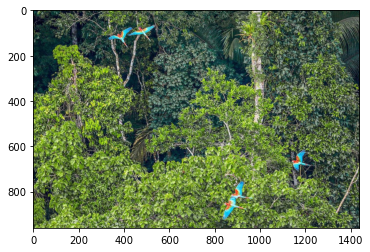

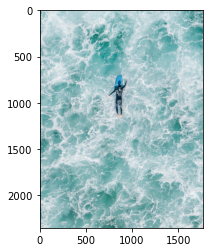

In [1]:
# import libraries and read image
import numpy as np
import cv2
import matplotlib.pyplot as plt

birds = cv2.imread('im03.jpg') 
birds = cv2.cvtColor(birds, cv2.COLOR_BGR2RGB)
plt.imshow(birds);
plt.show()

swimmer = cv2.imread('im04.jpg') 
swimmer = cv2.cvtColor(swimmer, cv2.COLOR_BGR2RGB)
plt.imshow(swimmer);
plt.show()

<div dir='rtl'>
    سپس جای اجسام را در تصاویر خالی می‌کنیم.
</div>

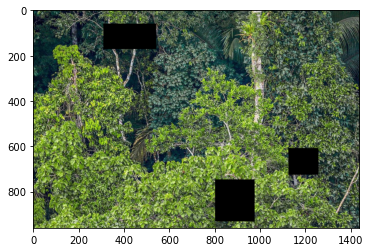

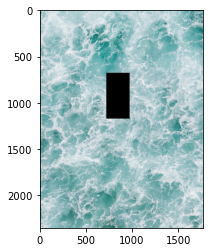

In [2]:
# a function to remove swimmer and birds from the images
def delete_areas(img, areas):
    for area in areas:
        img[area[0][0]:area[1][0], area[0][1]:area[1][1]] = 0
    return img

areas1 = [[[60, 310], [172, 542]], [[746, 802], [931, 976]], [[608, 1125], [725, 1257]]]
areas2 = [[[678, 718], [1173, 970]]]

birds_with_hole = delete_areas(birds, areas1)
plt.imshow(birds_with_hole);
plt.show()
swimmer_with_hole = delete_areas(swimmer, areas2)
plt.imshow(swimmer_with_hole);
plt.show()

<div dir='rtl'>
    مشابه قسمت قبل 
    texture synthesis
    را فقط برای قسمت مشکی اجرا می‌کنیم.
    فقط اینجا باید به سمت پایین و سمت راست کادر نیز توجه کنیم.
    برای این کار دو تصویر را در جهت‌های مختلف
    flip
    می‌کنیم و همان 
    min_cut
     قسمت قبل را روی آن اعمال می‌کنیم.
</div>

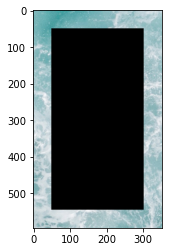

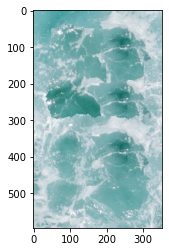

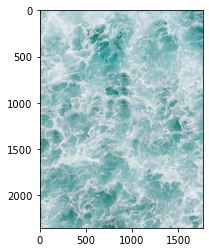

True

In [186]:
# template match using cv2.matchTemplate
def template_match(image, template, patch_size=50, margin=20):
    image_without_margin = image[margin:image.shape[0]-margin-patch_size][margin:image.shape[1]-margin-patch_size]
    result = cv2.matchTemplate(image_without_margin, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_loc[0] + margin, max_loc[1] + margin
    

# find min_cut for patches filled from left to right or up to down
def min_cut_from_left_or_up(patch1, patch2, overlap, direction):
    errors = np.sum((patch1 - patch2) ** 2, axis=2)
    dp = np.ones(errors.shape) * np.inf
    best_neighbors = [[(0, 0) for j in range(errors.shape[1])] for i in range(errors.shape[0])]
    
    if direction == 0:
        dp[0, :] = errors[0, :]
        for i in range(1, dp.shape[0]):
            for j in range(dp.shape[1]):
                best_neighbors[i][j] = (i - 1, min(j, overlap))
                for neighbor in range(max(0, j - 1), min(j + 2, dp.shape[1], overlap)):
                    if dp[i - 1][neighbor] + errors[i][j] < dp[i][j]:
                        dp[i][j] = dp[i - 1][neighbor] + errors[i][j]
                        best_neighbors[i][j] = (i - 1, neighbor)
    else: 
        dp[:, 0] = errors[:, 0]                
        for j in range(1, dp.shape[1]):
            for i in range(dp.shape[0]):
                best_neighbors[i][j] = (min(i, overlap), j - 1)
                for neighbor in range(max(0, i - 1), min(i + 2, dp.shape[0], overlap)):
                    if dp[neighbor][j - 1] + errors[i][j] < dp[i][j]:
                        dp[i][j] = dp[neighbor][j - 1] + errors[i][j]
                        best_neighbors[i][j] = (neighbor, j - 1)
    
    if direction == 0:
        i, j = dp.shape[0] - 1, np.argmin(dp[-1])
    else:
        i, j = np.argmin(dp[:, -1]), dp.shape[1] - 1
    
    mixed_patch = np.array(patch2)
    while i > 0 or j > 0:
        neigh_i, neigh_j = best_neighbors[i][j]
        if direction == 0:
            mixed_patch[i, :j] = patch1[i, :j]
        else:
            mixed_patch[:i, j] = patch1[:i, j]
        i, j = neigh_i, neigh_j
    
    return mixed_patch


# find min_cut for different flips
def min_cut(patch1, patch2, overlap, flip):
    if flip is not None:
        patch1 = cv2.flip(np.array(patch1), flip)
        patch2 = cv2.flip(np.array(patch2), flip)
    patch2 = min_cut_from_left_or_up(patch1, patch2, overlap, 1)
    mixed_patch = min_cut_from_left_or_up(patch1, patch2, overlap, 0)
    if flip is not None:
        mixed_patch = cv2.flip(np.array(mixed_patch), flip)
    return mixed_patch


# a function to perform texture synthesis
def texture_synthesis(image, to_fill, patch_size=200, margin=0, overlap_c=0.3):
    overlap = int(overlap_c * patch_size)
    
    ni = int(np.ceil((to_fill.shape[0] - overlap)/(patch_size - overlap)))
    nj = int(np.ceil((to_fill.shape[1] - overlap)/(patch_size - overlap)))
    
    for i_total in range(ni):
        for j_total in range(nj):
            y = i_total * (patch_size - overlap)
            x = j_total * (patch_size - overlap)
            
            overlapping_patch = to_fill[y:y+patch_size, x:x+patch_size]
            patch_x, patch_y = template_match(image, overlapping_patch, margin=margin, patch_size=patch_size)
            new_patch = image[patch_y:patch_y+min(patch_size, overlapping_patch.shape[0]),
                              patch_x:patch_x+min(patch_size, overlapping_patch.shape[1])]
            
            mixed_patch = min_cut(overlapping_patch, new_patch, overlap, -1) # flip both sides
            mixed_patch = min_cut(overlapping_patch, mixed_patch, overlap, 1) # flip y axis
            mixed_patch = min_cut(overlapping_patch, mixed_patch, overlap, 0) # flip x axis
            mixed_patch = min_cut(overlapping_patch, mixed_patch, overlap, 2) # no flips
            
            # fill blank area with template matched patch
            r, g, b = cv2.split(mixed_patch)
            rn, gn, bn = cv2.split(new_patch)
            mixed_patch = cv2.merge((np.where(r+g+b==0, rn, r),
                                     np.where(r+g+b==0, gn, g),
                                     np.where(r+g+b==0, bn, b)))
            to_fill[y:y+mixed_patch.shape[0], x:x+mixed_patch.shape[1]] = mixed_patch
    plt.imshow(to_fill);
    plt.show()
    return to_fill
                

# a function to perform template match for each blanck area seperately
def fill_holes(img, areas, using_area, patch_size=200, overlap_c=0.3):
    img = np.array(img)
    for area in areas:
        y_start, y_end = area[0][0] - 50, area[1][0] + 50
        x_start, x_end = area[0][1] - 50, area[1][1] + 50
        to_fill = np.array(img[y_start:y_end, x_start:x_end])
        plt.imshow(to_fill);
        plt.show()
        img[y_start:y_end, x_start:x_end] = texture_synthesis(using_area, to_fill, patch_size=200, overlap_c=0.3)
    return img
        
    
new_swimmer = fill_holes(swimmer_with_hole, areas2, swimmer_with_hole[1200:], patch_size=200, overlap_c=0.3) 
plt.imshow(new_swimmer);
plt.show()
save = cv2.cvtColor(new_swimmer, cv2.COLOR_RGB2BGR)
cv2.imwrite("res16.jpg", save)

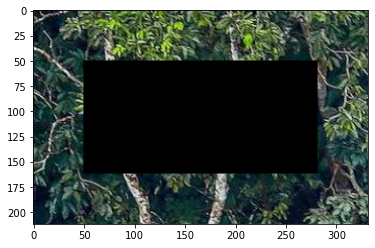

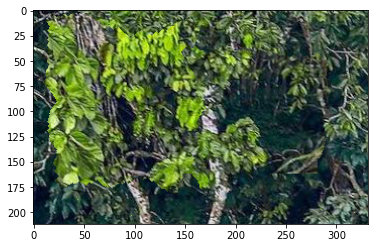

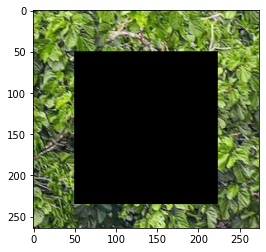

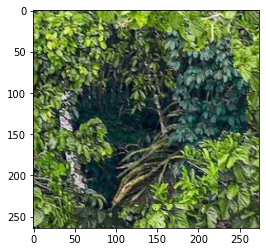

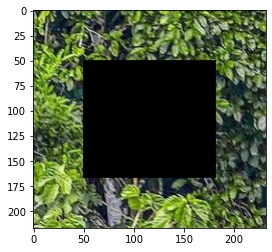

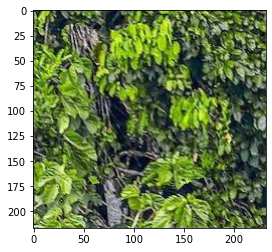

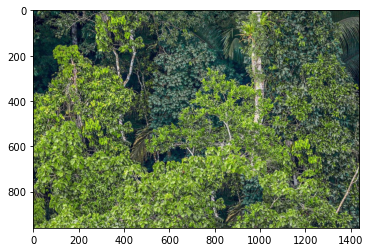

True

In [187]:
new_birds = fill_holes(birds_with_hole, areas1, birds_with_hole[200:,:700], patch_size=100, overlap_c=0.3) 
plt.imshow(new_birds);
plt.show()
save = cv2.cvtColor(new_birds, cv2.COLOR_RGB2BGR)
cv2.imwrite("res15.jpg", save)